In [1]:
## Libraries:

# a) Bond graphs
import BondGraphTools as bgt

# b) Data extraction
from pyomexmeta import RDF, eUriType
import os
import sys
import xml.etree.ElementTree as ET
import rdflib
from lxml import etree
import re

# c) General
import copy
import difflib
import numpy as np
import pandas as pd
import math
import operator as op
import ast
import re

# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams
import matplotlib.image as mpimg

# sbml
from libsbml import*
import simplesbml 

# Integration and fitting
from scipy.optimize import curve_fit, minimize, least_squares, newton_krylov, basinhopping
from scipy  import integrate
import scipy.stats as stats

The tests rely on tellurium to construct the models
Since tellurium is not installed the tests can't be run
If you want to run the tests, pip install tellurium first


In [2]:
locations=['/Users/nsha457/Documents/Jupyter_files/SBML_AnnotMerge/halfgloucose to AcCOA/BIOMD0000000017/BIOMD0000000017.xml',
           '/Users/nsha457/Documents/Jupyter_files/SBML_AnnotMerge/TCA cycle/MODEL1004070000/MODEL1004070000_url.xml']
simulations = ['/Users/nsha457/Documents/Jupyter_files/SBML_AnnotMerge/halfgloucose to AcCOA/BIOMD0000000017/solutions.csv',
            '/Users/nsha457/Documents/Jupyter_files/SBML_AnnotMerge/TCA cycle/MODEL1004070000/solutions.csv']

In [3]:
def watchdog(idAndAnnotations):
    
    # Finding identical annotations among the entities (should return Null)
    checkSimilarities = True
    for i in range(len(idAndAnnotations.keys())):
        for j in range(i+1,len(idAndAnnotations.keys())):
            if idAndAnnotations[list(idAndAnnotations)[i]] == idAndAnnotations[list(idAndAnnotations)[j]]:
                print("Pairs with identical annotations in the same model: ",list(idAndAnnotations)[i],list(idAndAnnotations)[j])
                print('----------')
                print('\n')
                print('Change the annotations of the entities/their compartment to be distinctive.')
                checkSimilarities = False

                img = mpimg.imread('Watchdog.jpg')
                imgplot = plt.imshow(img)
                plt.show()
                
    return checkSimilarities

In [4]:
# Reading and extracting annotations from the sbml files

def annotationExtraction(address,model_lib):

    modelURI = SBase.getURI(model_lib) 

    root=ET.parse(open(address)).getroot()
    idAndAnnotations = {}
    compartments=[]
    for child in root:
        for grand in child:
            if grand.tag == '{'+str(modelURI)+'}'+'listOfCompartments':
                for g in grand:
                    for g1 in g:
                        for g2 in g1:
                            for g3 in g2:
                                for g4 in g3:
                                    for g5 in g4:
                                        for g6 in g5:
                                            compartments.append((g.attrib.get('id'),g6.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}resource')))



            if grand.tag == '{'+str(modelURI)+'}'+'listOfSpecies':
                for g in grand: 
                    idAndAnnotations[g.attrib.get('id')] = []
                    for i,j in compartments:
                        if g.attrib.get('compartment') == i:
                            idAndAnnotations[g.attrib.get('id')].append(j)
                    for g1 in g:
                        for g2 in g1:
                            for g3 in g2:
                                for g4 in g3:
                                    for g5 in g4:
                                        for g6 in g5:
                                            idAndAnnotations[g.attrib.get('id')].append(g6.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}resource'))
  
    checkSimilarities = watchdog(idAndAnnotations)
    
    if checkSimilarities == True:                                    
        return[compartments,idAndAnnotations]
    else:
        return


In [5]:
def reactionsCategorizing(model_lib,model_simple,compartments,idAndAnnotations):
    
    reaction_reactants={}; reaction_products={}; Synthesis=[]; Dtype=[]

    for reaction in model_simple.getListOfReactionIds():
        reaction_reactants[reaction]=[]
        reaction_products[reaction]=[]

        reactNum=model_simple.getNumReactants(reaction)
        prodNum=model_simple.getNumProducts(reaction)

        if reactNum is 0:
            Synthesis.append(reaction)
        if prodNum is 0:
            Dtype.append(reaction)


        for i in range(reactNum):
            for name,identifier in compartments:
                if idAndAnnotations[model_simple.getReactant(reaction, i)] ==  [str(identifier)]:  # if a component has no annotation but the one for any of the compartments, don't use its annotation
                    reaction_reactants[reaction].append((model_simple.getReactantStoichiometry(reaction, i), \
                                                 model_simple.getReactant(reaction, i)))
                    break
                else:
                    reaction_reactants[reaction].append((model_simple.getReactantStoichiometry(reaction, i), \
                                                         idAndAnnotations[model_simple.getReactant(reaction, i)]))
                    break


        for ii in range(prodNum):
            for name,identifier in compartments:
                if idAndAnnotations[model_simple.getProduct(reaction, ii)] ==  [str(identifier)]:  # if a component has no annotation but the one for any of the compartments, don't use its annotation
                    reaction_products[reaction].append((model_simple.getProductStoichiometry(reaction, ii), \
                                                 model_simple.getProduct(reaction, ii)))
                    break
                else:
                    reaction_products[reaction].append((model_simple.getProductStoichiometry(reaction, ii), \
                                                         idAndAnnotations[model_simple.getProduct(reaction, ii)]))
                    break
            


    reversibles=[]; irreversibles=[]; 
    for (reaction,r) in zip(model_simple.getListOfReactionIds(),range(len(model_lib.getListOfReactions()))):

        if model_lib.getListOfReactions()[r].getReversible() is True:
            reversibles.append(reaction)
        elif reaction not in [synth for synth in Synthesis] and reaction not in [d for d in Dtype]:
            irreversibles.append(reaction)  

 
    speciesId=[]
    for species in model_simple.getListOfAllSpecies():
        for reaction in reversibles+irreversibles:
            for stoichiometry,reactant in reaction_reactants[reaction]:
                if species in [x for x in idAndAnnotations if idAndAnnotations[x]==reactant] and species not in [d for d in speciesId]:
                    speciesId.append(species)

            for stoichiometry,product in reaction_products[reaction]:
                if species in [x for x in idAndAnnotations if idAndAnnotations[x]==product] and species not in [d for d in speciesId]:
                    speciesId.append(species)


    return [speciesId,reversibles,irreversibles,reaction_reactants,reaction_products,Synthesis,Dtype]

In [6]:
# Unifying all the concentrations into micro Mole (uM)

def unitConversion(solutions):
    print('Enter the unit for concentration in the model ("pM, nM, uM, mM, M"): ')
    unit=str(input())
    
    print('Enter a normalisation factor for concentration ("enter 1 if you wish no normalisation"): ')
    normalisationFactor = float(input())
    
    if unit == "M":
        for column in solutions:
            if column != 'Time' and column != 'compartment':
                solutions[column]=solutions[column].apply(lambda x: x*1e6*normalisationFactor)
    if unit == "mM":
        for column in solutions:
            if column != 'Time' and column != 'compartment':
                solutions[column]=solutions[column].apply(lambda x: x*1e3*normalisationFactor)
    if unit == "uM":
        for column in solutions:
            if column != 'Time' and column != 'compartment':
                solutions[column]=solutions[column].apply(lambda x: x*normalisationFactor)
    if unit == "nM":
        for column in solutions:
            if column != 'Time' and column != 'compartment':
                solutions[column]=solutions[column].apply(lambda x: x*1e-3*normalisationFactor)
    if unit == "pM":
        for column in solutions:
            if column != 'Time' and column != 'compartment':
                solutions[column]=solutions[column].apply(lambda x: x*1e-6*normalisationFactor)
                
    if unit=='uM':
        print('No unit conversion was required for this model and normalised by a factor of ',normalisationFactor)
    else:
        print('Units converted from ',unit,' to uM and normalised by a factor of ',normalisationFactor)
        
    
        
    return solutions
        

In [7]:
solutions1 = pd.read_csv(simulations[0])  
unifiedSolution1 = unitConversion(solutions1)


Enter the unit for concentration in the model ("pM, nM, uM, mM, M"): 
mM
Enter a normalisation factor for concentration ("enter 1 if you wish no normalisation"): 
0.001
Units converted from  mM  to uM and normalised by a factor of  0.001


In [8]:
solutions2 = pd.read_csv(simulations[1])  
unifiedSolution2 = unitConversion(solutions2)

Enter the unit for concentration in the model ("pM, nM, uM, mM, M"): 
uM
Enter a normalisation factor for concentration ("enter 1 if you wish no normalisation"): 
1
No unit conversion was required for this model and normalised by a factor of  1.0


In [9]:
def allIrreversible(speciesId,irreversibles,reaction_reactants,reaction_products,solutions,idAndAnnotations):
    

    kineticRatio = []
    for reaction in irreversibles:
        RSS = 1; PSS=1;
        for stoichiometry,reactant in reaction_reactants[reaction]:

            diff = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]].diff() 
            diff.fillna(method='bfill', inplace=True)
            if diff.all() == 0 and solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]].all() == 0:
                RSS = RSS * 1
            else:

                length = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]].size
                RSS = RSS * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]][length-1],stoichiometry)

        for stoichiometry,product in reaction_products[reaction]:

            diff = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]].diff() 
            diff.fillna(method='bfill', inplace=True)
            if diff.all() == 0 and solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]].all() == 0:
                PSS = PSS * 1
            else:
                length = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]].size
                PSS = PSS * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]][length-1],stoichiometry)

        kineticRatio.append(1e-3*RSS/PSS)


    trueValues = copy.deepcopy(kineticRatio) 


    rowM=[]
    for s in speciesId:
         rowM.append([x for x in idAndAnnotations.values() if idAndAnnotations[s]==x][0])
    for reaction in irreversibles:
        rowM.append(reaction+' X')


                
    return[trueValues,rowM]

In [10]:
def irreversibleAndReversible(model_simple,speciesId,reversibles,irreversibles,reaction_reactants,reaction_products,solutions,idAndAnnotations):
    
    Kp_to_Kr = []

    for reaction in reversibles:

        phi_Xr_1 = 1
        phi_Xp_1 = 1
        phi_Xr_e = 1
        phi_Xp_e = 1


        for stoichiometry,reactant in reaction_reactants[reaction]:

            phi_Xr_1 = phi_Xr_1 * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]][1],stoichiometry)
            phi_Xr_e = phi_Xr_e * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]][len(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]])-1],stoichiometry)
   
        for stoichiometry,product in reaction_products[reaction]:        
            phi_Xp_1 = phi_Xp_1 * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]][1],stoichiometry)
            phi_Xp_e = phi_Xp_e * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]][len(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]])-1],stoichiometry)
            
        # compartment for a reactant/species in the reaction
        
        compartmentId1 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0])
        compartmentId2 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==product][0])
        compartmentVolume1 = model_simple.getCompartmentVolume(compartmentId1)
        compartmentVolume2 = model_simple.getCompartmentVolume(compartmentId2)
            
            
        sigma = solutions[reaction][len(solutions[reaction])-1] / solutions[reaction][1]
        Kp_to_Kr.append((compartmentVolume1*(sigma*phi_Xr_1 - phi_Xr_e))/(compartmentVolume2*(sigma*phi_Xp_1 - phi_Xp_e)))
            

    trueValues = Kp_to_Kr 


    rowM=[]
    for s in speciesId:
         rowM.append([x for x in idAndAnnotations.values() if idAndAnnotations[s]==x][0])


    thermodynamicsAdd=[]
    rowMAdd=[]
    for reaction in irreversibles:
        RSS = 1; PSS=1;
        for stoichiometry,reactant in reaction_reactants[reaction]:

            diff = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]].diff() 
            diff.fillna(method='bfill', inplace=True)
            if diff.all() == 0 and solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]].all() == 0:
                pass
            else:

                length = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]].size
                RSS = RSS * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]][length-1],stoichiometry)

        for stoichiometry,product in reaction_products[reaction]:

            diff = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]].diff() 
            diff.fillna(method='bfill', inplace=True)
            if diff.all() == 0 and solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]].all() == 0:
                pass
            else:
                length = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]].size
                PSS = PSS * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]][length-1],stoichiometry)

        thermodynamicsAdd = thermodynamicsAdd + [1e-3*RSS/PSS]
        rowMAdd = rowMAdd + [reaction+' X']

    
    
    return[trueValues,rowM,thermodynamicsAdd,rowMAdd]

In [11]:
# First model
address1=locations[0]

reader = SBMLReader()
document = reader.readSBML(address1)
model_lib1 = document.getModel()
model_simple1 = simplesbml.loadSBMLFile(address1)

    
    
[compartments1,idAndAnnotations1]=annotationExtraction(address1,model_lib1)
[speciesId1,reversibles1,irreversibles1,reaction_reactants1,reaction_products1,Synthesis1,Dtype1] = reactionsCategorizing(model_lib1,model_simple1,compartments1,idAndAnnotations1)            

[trueValues1,rowM1] = allIrreversible(speciesId1,irreversibles1,reaction_reactants1,reaction_products1,unifiedSolution1,idAndAnnotations1)

In [12]:
# Second model
address2=locations[1]

reader = SBMLReader()
document = reader.readSBML(address2)
model_lib2 = document.getModel()
model_simple2 = simplesbml.loadSBMLFile(address2)

    
    
[compartments2,idAndAnnotations2]=annotationExtraction(address2,model_lib2)
[speciesId2,reversibles2,irreversibles2,reaction_reactants2,reaction_products2,Synthesis2,Dtype2] = reactionsCategorizing(model_lib2,model_simple2,compartments2,idAndAnnotations2)            

[trueValues2,rowM2,thermodynamicsAdd2,rowMAdd2] = irreversibleAndReversible(model_simple2,speciesId2,reversibles2,irreversibles2,reaction_reactants2,reaction_products2,unifiedSolution2,idAndAnnotations2)

# Save thermodynamics2 for later to be added. 
# It's not included in the calculations because it's been already calculated.

In [13]:
# Calculating the thermodynamic values

# M: stoichiometry matrix 

trueValues=trueValues1+trueValues2
rowM1_no_duplicate = [item1 for item1 in rowM1 if item1 not in rowM2]
rowM = rowM1_no_duplicate + rowM2

irreversibles=irreversibles1+irreversibles2
reversibles=reversibles1+reversibles2

M = np.zeros([len(trueValues),len(rowM)])  

if reversibles1 == []:
    for i,reaction in zip(range(len(irreversibles1)),irreversibles1):

        for stoichiometry,reactant in reaction_reactants1[irreversibles1[i]]:
            for r in range(len(rowM)):     
                if rowM[r] == reactant:  
                    M[i][r] = -stoichiometry


        for stoichiometry,product in reaction_products1[irreversibles1[i]]:
            for r in range(len(rowM)):     
                if rowM[r] == product:                    
                    M[i][r] = stoichiometry

        for r in range(len(rowM)): 
            if rowM[r] == reaction+' X':
                M[i][r] = 1


lastline = copy.deepcopy(i+1)

if irreversibles2 != [] and reversibles2 != []:
    for reaction,i in zip(reversibles2,range(lastline,lastline+len(reversibles2))):
        for stoichiometry,reactant in reaction_reactants2[reaction]:
            for r in range(len(rowM)):     
                if rowM[r] == reactant:  
                    M[i][r] = -stoichiometry


        for stoichiometry,product in reaction_products2[reaction]:
            for r in range(len(rowM)):     
                if rowM[r] == product:                    
                    M[i][r] = stoichiometry
                    
                    
logTrueValues = [];

for k in trueValues:
    logTrueValues.append(math.log(k))

logTrueValues = np.array(logTrueValues)


Mpinv = np.linalg.pinv(np.array(M))
logU = Mpinv.dot(logTrueValues)

thermodynamics = [math.exp(i) for i in list(logU)]
# for i in range(len(thermodynamics)):
#         print(rowM[i],' ==> ',thermodynamics[i])
# for i in range(len(thermodynamicsAdd2)):
#         print(rowMAdd2[i],' ==> ',thermodynamicsAdd2[i])

rowM = rowM + rowMAdd2
thermodynamics = thermodynamics + thermodynamicsAdd2

In [14]:
# Finding the reaction rate constants (first model)

reactionRates = {}
for reaction in  irreversibles1:

    reactantsSpecies=[]
    productsSpecies=[]

    K_reactants = 1
    K_products = 1

    solve=tuple()

    for stoichiometry,reactant in reaction_reactants1[reaction]:
        reactantsSpecies.append(reactant)        
        solve=solve+(pow(unifiedSolution1[[x for x in idAndAnnotations1 if idAndAnnotations1[x]==reactant][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == reactant:
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)   

    for stoichiometry,product in reaction_products1[reaction]:
        productsSpecies.append(product)        
        solve=solve+(pow(unifiedSolution1[[x for x in idAndAnnotations1 if idAndAnnotations1[x]==product][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == product:
                K_products = K_products * pow(thermodynamics[i],stoichiometry)

    for r in range(len(rowM)):
        if rowM[r] == reaction+' X':
            K_x = thermodynamics[r]


    def func(X, r):


        reactants = np.ones((len(unifiedSolution1['Time'])))
        products= np.ones((len(unifiedSolution1['Time'])))


        for x in range(0,len(reactantsSpecies)):
            reactants = reactants * X[x]            

        for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
            products = products * X[x]


        v = r*(K_reactants*reactants- K_products*products*K_x)


        return v


    bounds=[[0],[np.inf]]
    popt, pcov = curve_fit(func,solve,unifiedSolution1[reaction], maxfev=300000, bounds=bounds)
    if popt[0]==1: 
        popt, pcov = curve_fit(func,solve,unifiedSolution1[reaction], maxfev=300000, method='lm')

    reactionRates[reaction]=popt[0]

In [15]:
reactionRates

{'R1': 2.2235545648500024,
 'R2': 4.000556151625503,
 'R3': 0.21239999435826354,
 'R4': 0.014734295777255865,
 'R5': 6.359624640034161,
 'R6': 0.03552532185679064,
 'R7': 4.557052051834544,
 'R8': 5.072368749411648e-05,
 'R9': 0.027423498819120706,
 'R10': 2.5877349458469627,
 'R11': 5.628937667446544e-09,
 'R12': 255.2343956593184,
 'R13': 0.33033362700224317,
 'R14': 1.5650163882068005e-05}

In [16]:
# Finding the reaction rate constants (second model)

for reaction in  reversibles2:

    reactantsSpecies=[]
    productsSpecies=[]

    K_reactants = 1
    K_products = 1

    solve=tuple()

    for stoichiometry,reactant in reaction_reactants2[reaction]:
        reactantsSpecies.append(reactant)        
        solve=solve+(pow(unifiedSolution2[[x for x in idAndAnnotations2 if idAndAnnotations2[x]==reactant][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == reactant:
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)   


    for stoichiometry,product in reaction_products2[reaction]:
        productsSpecies.append(product)        
        solve=solve+(pow(unifiedSolution2[[x for x in idAndAnnotations2 if idAndAnnotations2[x]==product][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == product:
                K_products = K_products * pow(thermodynamics[i],stoichiometry)

    # compartment for a reactant/species in the reaction
    compartmentId1 = model_simple2.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations2 if idAndAnnotations2[x]==reactant][0])
    compartmentId2 = model_simple2.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations2 if idAndAnnotations2[x]==product][0])
    compartmentVolume1 = model_simple2.getCompartmentVolume(compartmentId1)
    compartmentVolume2 = model_simple2.getCompartmentVolume(compartmentId2)


    def func(X, r):


        reactants = np.ones((len(unifiedSolution2['Time'])))
        products= np.ones((len(unifiedSolution2['Time'])))


        for x in range(0,len(reactantsSpecies)):
            reactants = reactants * X[x]            

        for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
            products = products * X[x]


        v = r*(compartmentVolume1*K_reactants*reactants- compartmentVolume2*K_products*products)


        return v

    bounds=[[0],[np.inf]]
    popt, pcov = curve_fit(func,solve,unifiedSolution2[reaction], maxfev=300000, bounds=bounds)
    if popt[0]==1: 
        popt, pcov = curve_fit(func,solve,unifiedSolution2[reaction], maxfev=300000, method='lm')

    reactionRates[reaction]=popt[0]


for reaction in  irreversibles2:

    reactantsSpecies=[]
    productsSpecies=[]

    K_reactants = 1
    K_products = 1

    solve=tuple()

    for stoichiometry,reactant in reaction_reactants2[reaction]:
        reactantsSpecies.append(reactant)        
        solve=solve+(pow(unifiedSolution2[[x for x in idAndAnnotations2 if idAndAnnotations2[x]==reactant][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == reactant:
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)   

    for stoichiometry,product in reaction_products2[reaction]:
        productsSpecies.append(product)        
        solve=solve+(pow(unifiedSolution2[[x for x in idAndAnnotations2 if idAndAnnotations2[x]==product][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == product:
                K_products = K_products * pow(thermodynamics[i],stoichiometry)

    # compartment for a reactant/species in the reaction
    compartmentId1 = model_simple2.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations2 if idAndAnnotations2[x]==reactant][0])
    compartmentId2 = model_simple2.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations2 if idAndAnnotations2[x]==product][0])
    compartmentVolume1 = model_simple2.getCompartmentVolume(compartmentId1)
    compartmentVolume2 = model_simple2.getCompartmentVolume(compartmentId2)


    for r in range(len(rowM)):
        if rowM[r] == reaction+' X':
            K_x = thermodynamics[r]


    def func(X, r):


        reactants = np.ones((len(unifiedSolution2['Time'])))
        products= np.ones((len(unifiedSolution2['Time'])))


        for x in range(0,len(reactantsSpecies)):
            reactants = reactants * X[x]            

        for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
            products = products * X[x]


        v = r*(compartmentVolume1*K_reactants*reactants- compartmentVolume2*K_products*products*K_x)


        return v


    bounds=[[0],[np.inf]]
    popt, pcov = curve_fit(func,solve,unifiedSolution2[reaction], maxfev=300000, bounds=bounds)
    if popt[0]==1: 
        popt, pcov = curve_fit(func,solve,unifiedSolution2[reaction], maxfev=300000, method='lm')

    reactionRates[reaction]=popt[0]

In [17]:
def BGconstruction(compartments,idAndAnnotations,reversibles,irreversibles,reaction_reactants,reaction_products,speciesId,solutions,reactionRates,thermodynamics,rowM,Synthesis,Dtype):
    
    idealGassConstant=8.314
    T= 310
    
    BGspecies=[]; BGzeroJunc=[]; BGreactions=[]; oneJunc_reac=[]; oneJunc_prod=[]; TF=[];

    for reaction in reversibles + irreversibles:

        BGreactions.append(bgt.new("Re", name=reaction, library="BioChem", value={'R':idealGassConstant, 'T':T}))

        oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction)) 
        oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction))


        for stoichiometry,reactant in reaction_reactants[reaction]:
            if stoichiometry != 1:
                TF.append(bgt.new('TF', name='oneReac '+reaction+' '+str(reactant), value=stoichiometry))

        for stoichiometry,product in reaction_products[reaction]:
            if stoichiometry != 1:
                TF.append(bgt.new('TF', name='oneProd '+reaction+' '+str(product), value=1/stoichiometry))

        if reaction in irreversibles:
            BGspecies.append(bgt.new("Ce_S", name=reaction+' X', library="BioChem", value={'R':idealGassConstant, 'T':T}))
            BGzeroJunc.append(bgt.new("0", name=reaction+' X'))  



    for species in speciesId:
        
        for name,identifier in compartments:
            if idAndAnnotations[species] ==  [str(identifier)]:  # if a component has no annotation but the one for any of the compartments, don't use its annotation
                speciesAnnotated = copy.deepcopy(species)
                break
            else:
                speciesAnnotated = copy.deepcopy(idAndAnnotations[species])

        diff = solutions[species].diff() 
        diff.fillna(method='bfill', inplace=True)
        
        if (diff == 0).all() == False:
            BGspecies.append(bgt.new("Ce", name=speciesAnnotated, library="BioChem", value={'R':idealGassConstant, 'T':T}))
            BGzeroJunc.append(bgt.new("0", name=speciesAnnotated)) 
            
        elif (diff == 0).all() == True:
            BGspecies.append(bgt.new("Ce_S", name=speciesAnnotated, library="BioChem", value={'R':idealGassConstant, 'T':T}))
            BGzeroJunc.append(bgt.new("0", name=speciesAnnotated)) 
            


            
    # Setting the values in BGs

    for BGreaction in BGreactions:
        if BGreaction.name in [key for key in reactionRates]:
            bgt.set_param(BGreaction,'r',reactionRates[BGreaction.name])


    for bg in BGspecies:  
        for i in range(len(rowM)):
#             if str(rowM[i]) in idAndAnnotations:
            for name,identifier in compartments:
                if rowM[i] ==  [str(identifier)]:
                    if bg.name == rowM[i]:
                        bgt.set_param(bg,'k',thermodynamics[i])     

                    break
                elif bg.name ==  rowM[i]:
                    bgt.set_param(bg,'k',thermodynamics[i]) 


    for reaction in irreversibles:
        for bg in BGspecies: 
            if bg.name == reaction+' X':
                for i in range(len(rowM)):
                    if rowM[i] == reaction+' X':
                        bgt.set_param(bg,'k',thermodynamics[i])
    
    
            
# connections
    connections = []

    for z in BGzeroJunc:
        for s in BGspecies:
            if (z.name) == (s.name):
                connections.append([z,s])


    for r in BGreactions:
        for oneR,oneP in zip(oneJunc_reac,oneJunc_prod):    
            if 'oneReac '+r.name == oneR.name:
                connections.append([oneR,r])

            if 'oneProd '+r.name == oneP.name:
                connections.append([r,oneP])



    for reaction in reversibles + irreversibles:
        for oneR in oneJunc_reac:
            for xR in oneR.name.split(sep=" "):
                if (reaction) == (xR):

                    for z in BGzeroJunc:
                        for stoichiometry,reactant in reaction_reactants[reaction]:
                            if  z.name == reactant:
                                if stoichiometry!=1:
                                    for TFcomp in TF:
                                        if TFcomp.name == 'oneReac '+reaction+' '+str(reactant):
                                            connections.append([z,(TFcomp,0)])
                                            connections.append([(TFcomp,1),oneR])
                                else:
                                    connections.append([z,oneR])


        for oneP in oneJunc_prod:
            for xP in oneP.name.split(sep=" "):
                if (reaction) == (xP):

                    for z in BGzeroJunc:
                        for stoichiometry,product in reaction_products[reaction]:
                            if z.name == product:
                                if stoichiometry!=1:
                                    for TFcomp in TF:
                                        if TFcomp.name == 'oneProd '+reaction+' '+str(product):
                                            connections.append([oneP,(TFcomp,0)])
                                            connections.append([(TFcomp,1),z])
                                else:
                                    connections.append([oneP,z])

                        if reaction in irreversibles:
                            if  z.name == reaction+' X':
                                connections.append([oneP,z])
                                
                                
                                
# Adding the boundary conditions of Sf/Se the model for Synthesis/Dtype(Degradation,Decay )

   
    for reaction in Dtype:
        for stoichiometry,reactant in reaction_reactants[reaction]:
            for  i in range(len(rowM)):
                if rowM[i] == reactant:
                    K_reactants = thermodynamics[i]


        def funcDtype(X, r):

            products= np.ones((len(solutions['Time'])))          


            v = r*(K_reactants*X - (0.001*K_reactants)*products)

            return v

        bounds=[[0],[np.inf]]
        popt, pcov = curve_fit(funcDtype,solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],solutions[reaction], maxfev=5000, bounds=bounds)
        if popt[0]==1:
            popt, pcov = curve_fit(funcDtype,solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],solutions[reaction], maxfev=5000, method='lm')

        rateDtype = popt[0]


        BGreactions.append(bgt.new("Re", name=reaction, library="BioChem", value={'r':rateDtype ,'R':idealGassConstant, 'T':T}))

        for bg in [s for s in BGspecies if s.metamodel=='C' and s.name == reactant]:
            K_aux = 0.001 * bg._params['k']['value']
            BGspecies.append(bgt.new("Ce_S", name=reaction+' C_aux', library="BioChem", value={'k':K_aux ,'R':idealGassConstant, 'T':T}))

            for z in [junc for junc in BGzeroJunc if junc.name == reactant]:
                if stoichiometry != 1:
                    pass  # TF currently not defined for Dtypes and Synthesis

                else:
                    for bg in [r for r in BGreactions if r.name == reaction]:
                        connections.append([z,bg])
                        for s in [c for c in BGspecies if c.name == reaction+' C_aux']:
                            connections.append([bg,s]) 

                            
    components = []
    
    for reaction in Synthesis:
        components.append(bgt.new('Sf', name='Sf '+reaction))
        for stoichiometry,product in reaction_products[reaction]:
            for z in [junc for junc in BGzeroJunc if junc.name == product]:
                for bg in [sf for sf in BGmodel.components if sf.name == 'Sf '+reaction]:
                    connections.append([bg,z])


    components = [(tf,0) for tf in TF] + [(tf,1) for tf in TF] + BGspecies + BGzeroJunc + BGreactions + oneJunc_reac + oneJunc_prod
    
    return [components,connections]

In [18]:
[components1,connections1] = BGconstruction(compartments1,idAndAnnotations1,reversibles1,irreversibles1,reaction_reactants1,reaction_products1,speciesId1,unifiedSolution1,reactionRates,thermodynamics,rowM,Synthesis1,Dtype1)


In [19]:
for i in range(len(components1)):
    if type(components1[i]) != tuple and components1[i].metamodel == 'C':
        print(components1[i]._params['k']['value'])
    if type(components1[i]) != tuple and components1[i].metamodel == 'R':
        print(components1[i]._params['r']['value'])
    if type(components1[i]) == tuple:
        print(components1[i][0],components1[i][0]._params)
        

TF: oneReac R8 ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15361'] {'r': 2.0}
TF: oneReac R8 ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15361'] {'r': 2.0}
0.005152207578837648
0.6187662459266019
0.0014557179286738672
0.253494453919436
0.030538590307138364
0.07316158652789628
0.016037794424498254
0.5486045686361828
0.03765468306799562
0.0024079619089154127
0.03809605606800884
0.0005012055660439509
0.02237409112030779
0.03765468306799595
3.1854702064239317
0.08251049800654958
0.3139253972563814
12.11966991061705
26.562825292672095
0.44271375487787223
12.740144267965213
2.357966403069992
20.96593820038276
8.300790945814592
0.0305385903071382
4.561823439770508
0.01603779442449821
386.92022068841436
15.456400529496827
0.002407961908915417
0.03809605606800878
44.694552937274544
3.944859481295847
2.2235545648500024
4.000556151625503
0.21239999435826354
0.014734295777255865
6.359624640034161
0.03552532185679064
4.55705205183454

In [20]:
[components2,connections2] = BGconstruction(compartments2,idAndAnnotations2,reversibles2,irreversibles2,reaction_reactants2,reaction_products2,speciesId2,unifiedSolution2,reactionRates,thermodynamics,rowM,Synthesis2,Dtype2)
for i in range(len(components2)):
    if type(components2[i]) != tuple and components2[i].metamodel == 'C':
        print(components2[i]._params['k']['value'])
    if type(components2[i]) != tuple and components2[i].metamodel == 'R':
        print(components2[i]._params['r']['value'])
    if type(components2[i]) == tuple:
        print(components2[i][0],components2[i][0]._params)

1.852811607763427e-05
0.0031464106171078185
0.0005949213403540895
0.04381634103514594
4.422680100256199e-07
9.770717822260043e-07
9.823744334037436e-07
9.823745037660526e-07
0.015547355781925907
4.973010806722172e-05
6.514855145862591e-09
41.783164662400075
2.357966403069992
1.0000000000000002
1.970006706360175
0.47148336330887103
38.06581647592021
1.0766286250248946
1.0573837909983048
0.12688605491796345
0.047175641193025454
0.11888261580643344
0.010483475820672392
26.562825292672095
4.495536325329005
1.4130971820964033
0.7076654123083367
0.4495536325328947
0.022976258243332544
2.271526570314267
0.7359746087818296
1.5366209152126078
7.927385410445856
0.8478058854773167
0.44271375487787223
20.96593820038276
1.0
0.40270062890850883
1.0
1.0
0.0015076261460271675
2.4832342643974217
1.0
0.021204712649681413
19.187751999116085
0.11760143348933558
0.00945730404148117
2.364326010414676
78.81086701378443
635.9214043776102
4769.4105322266805
0.6506701214847087
0.042486588077653445
27.0754014912

In [21]:
listOfComponents={}; listOfConnections={};  idAndAnnotationsAll={}; solutionsAll={};

listOfComponents[0] = components1
listOfComponents[1] = components2

listOfConnections[0] = connections1
listOfConnections[1] = connections2

idAndAnnotationsAll[0] = idAndAnnotations1
idAndAnnotationsAll[1] = idAndAnnotations2

solutionsAll[0] = unifiedSolution1
solutionsAll[1] = unifiedSolution2

In [22]:
# Finding common 'C' components among the models. Here will be: lactate, AcCoA, halfglucose, pyruvate
commons={}
for i in range(len(listOfComponents.keys())):
    for j in range(i+1,len(listOfComponents.keys())):
        for component1 in listOfComponents[list(listOfComponents)[i]]:
            for component2 in listOfComponents[list(listOfComponents)[j]]:
                if (type(component1) != tuple and type(component2) != tuple) and \
                (component1.metamodel == 'C' and component2.metamodel == 'C') and \
                (component1.name == component2.name):
                    for identifier in component1.name:
                        if 'identifier' in identifier: # Making sure the names to be searched are the annotated ones
                            if str(component1.name) not in commons.keys():
                                commons[str(component1.name)]=[]
                                commons[str(component1.name)].append(i)
                                commons[str(component1.name)].append(j)
                            else:
                                if i not in commons[str(component1.name)]:
                                    commons[str(component1.name)].append(i)
                                if j not in commons[str(component1.name)]:
                                    commons[str(component1.name)].append(j)

In [23]:
commons

{"['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15361']": [0,
  1],
 "['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:24996']": [0,
  1],
 "['http://identifiers.org/go/GO:0005576', 'http://identifiers.org/chebi/CHEBI:17234']": [0,
  1],
 "['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15351']": [0,
  1]}

In [24]:
commonInitials={}
for key1 in commons: 
    for key2 in idAndAnnotationsAll:
        for ids in idAndAnnotationsAll[key2]:
            if str(idAndAnnotationsAll[key2][ids]) == str(key1) and key1 not in commonInitials:
                commonInitials[key1]=[]
                commonInitials[key1].append(solutionsAll[key2][str(ids)][0])
            elif str(idAndAnnotationsAll[key2][ids]) == str(key1) and key1 in commonInitials:
                commonInitials[key1].append(solutionsAll[key2][str(ids)][0])
                
preferredInitials={}
print('Common components found with the following initial conditions: ','\n')                
for key in commonInitials: 
    print(key,commonInitials[key])
print('\n','Enter your preferred initial condition for: ')
for key in commonInitials: 
    preferredInitials[key]=[]
    preferredInitials[key]=float(input(key))

Common components found with the following initial conditions:  

['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15361'] [1.0, 0.059]
['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:24996'] [0.1, 6.4]
['http://identifiers.org/go/GO:0005576', 'http://identifiers.org/chebi/CHEBI:17234'] [30.0, 50.0]
['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15351'] [0.0, 0.1]

 Enter your preferred initial condition for: 
['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15361']0.059
['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:24996']6.4
['http://identifiers.org/go/GO:0005576', 'http://identifiers.org/chebi/CHEBI:17234']50
['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15351']0.1


In [25]:
# Remove the repetitive components from "listOfComponents"

# print('Model number and the components to be reserved:','\n')
for key in commons:
    
    for i in range(1,len(commons[key])):
        modelCompKeep = list(commons[key])[0]
        modelCompRemove = list(commons[key])[i]
        
        # finding the 0-junction for the component to be reserved in the first model
        for k in range(len(listOfComponents[modelCompKeep])):  
            if type(listOfComponents[modelCompKeep][k]) != tuple and \
            listOfComponents[modelCompKeep][k].metamodel == '0' and \
            str(listOfComponents[modelCompKeep][k].name) == str(key):
                compToBeKept = listOfComponents[modelCompKeep][k]
                
                
        # Remove the repetitive components from "components"        
        for j in range(len(listOfComponents[modelCompRemove])): 
            if type(listOfComponents[modelCompRemove][j]) != tuple and \
            listOfComponents[modelCompRemove][j].metamodel == 'C' and \
            str(listOfComponents[modelCompRemove][j].name) == str(key):
                del listOfComponents[modelCompRemove][j]
                break
                
        # Remove the repetitive components from "connections" and replacing with the reserved one   
        for n in range(len(listOfConnections[modelCompRemove])):
            if len(listOfConnections[modelCompRemove][n])==2 and type(listOfConnections[modelCompRemove][n][1])!=tuple and \
            listOfConnections[modelCompRemove][n][1].metamodel=='C' and \
            str(listOfConnections[modelCompRemove][n][1].name)==str(key):
                del listOfConnections[modelCompRemove][n][1]
                listOfConnections[modelCompRemove][n].append(compToBeKept)
                break

In [26]:
BGmodel=bgt.new(name='BGmodel')

for model in listOfComponents:
    for comp in listOfComponents[model]:
        if type(comp)!=tuple:
            bgt.add(BGmodel,comp)
        else:
            if comp[0] not in BGmodel.components:
                bgt.add(BGmodel,comp[0])

for model in listOfConnections:
    for tail,head in listOfConnections[model]:
        bgt.connect(tail,head)

In [27]:
# Asking if the user needs to remove any reaction/component?

def ArbitraryRemoval(BGmodel):
    print('Enter the exact annotation of the component to be removed: ')
    toBeRemoved = str(input())
    for component in BGmodel.components:
        if str(component.name) == toBeRemoved:
            print('Is it the correct component (y/n)? ==>  ',component)
            answer = str(input())
            if answer == 'y':
                if component.metamodel is 'R':  # checking for removing a reaction
                    for tail,head in BGmodel.bonds:
                        if type(head[0]) != tuple and head[0].metamodel is 'R' and str(head[0].name) == str(component.name):
                            bgt.disconnect(tail[0], component)
                            print(tail[0],' and',component,' disconnected')
                            for x,y in BGmodel.bonds:
                                if type(y[0]) != tuple and y[0].metamodel is '1' and str(y[0].name) == str(tail[0].name):
                                    bgt.disconnect(x[0], tail[0])
                                    print(x[0],' and',tail[0],' disconnected')
                            
                            
                            BGmodel.remove(tail[0])
                            print(tail[0],' removed')
                        if type(tail[0]) != tuple and tail[0].metamodel is 'R' and str(tail[0].name) == str(component.name):
                            bgt.disconnect(head[0], component)
                            print(component,' and',head[0],' disconnected')
                            for x,y in BGmodel.bonds:
                                if type(x[0]) != tuple and x[0].metamodel is '1' and str(x[0].name) == str(head[0].name):
                                    bgt.disconnect(y[0], head[0])
                                    print(y[0],' and',head[0],' disconnected')
                            
                            
                            BGmodel.remove(head[0])
                            print(head[0],' removed')
                    
                    BGmodel.remove(component)
                    print(component, 'removed')
                    
    return

ArbitraryRemoval(BGmodel)

Enter the exact annotation of the component to be removed: 
R1
Is it the correct component (y/n)? ==>   R: R1
y
1: oneReac R1  and R: R1  disconnected
0: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:16761', 'http://identifiers.org/kegg.compound/C00008']  and 1: oneReac R1  disconnected
0: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15846', 'http://identifiers.org/kegg.compound/C00003']  and 1: oneReac R1  disconnected
0: ['http://identifiers.org/go/GO:0005576', 'http://identifiers.org/chebi/CHEBI:17234']  and 1: oneReac R1  disconnected
1: oneReac R1  removed
R: R1  and 1: oneProd R1  disconnected
0: R1 X  and 1: oneProd R1  disconnected
0: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15422', 'http://identifiers.org/kegg.compound/C00002']  and 1: oneProd R1  disconnected
0: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:16908', 'http://identifiers.org/kegg.comp

In [28]:
BGmodel.state_vars

{'x_0': (C: R1 X, 'q_0'),
 'x_1': (C: R2 X, 'q_0'),
 'x_2': (C: R3 X, 'q_0'),
 'x_3': (C: R4 X, 'q_0'),
 'x_4': (C: R5 X, 'q_0'),
 'x_5': (C: R6 X, 'q_0'),
 'x_6': (C: R7 X, 'q_0'),
 'x_7': (C: R8 X, 'q_0'),
 'x_8': (C: R9 X, 'q_0'),
 'x_9': (C: R10 X, 'q_0'),
 'x_10': (C: R11 X, 'q_0'),
 'x_11': (C: R12 X, 'q_0'),
 'x_12': (C: R13 X, 'q_0'),
 'x_13': (C: R14 X, 'q_0'),
 'x_14': (C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:16761', 'http://identifiers.org/kegg.compound/C00008'],
  'q_0'),
 'x_15': (C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15846', 'http://identifiers.org/kegg.compound/C00003'],
  'q_0'),
 'x_16': (C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15422', 'http://identifiers.org/kegg.compound/C00002'],
  'q_0'),
 'x_17': (C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:16908', 'http://identifiers.org/kegg.compound/C00004'],
  'q_0'),
 'x

In [29]:
x_0 = {}

for stateVar in BGmodel.state_vars:                   
    for key in idAndAnnotationsAll:
        for ids in idAndAnnotationsAll[key]:
            
            if str(BGmodel.state_vars[stateVar][0].name) in preferredInitials:
                x_0[stateVar] =  preferredInitials[str(BGmodel.state_vars[stateVar][0].name)]
            
            else:
                if str(BGmodel.state_vars[stateVar][0].name) == str(idAndAnnotationsAll[key][ids]):
                    x_0[stateVar] =  solutionsAll[key][str(ids)][0]
                elif str(BGmodel.state_vars[stateVar][0].name) == str(ids):
                    x_0[stateVar] =  solutionsAll[key][str(ids)][0]


for stateVar in BGmodel.state_vars:  
    if stateVar not in x_0:
        x_0[stateVar] =  1

In [77]:
## Uncomment and run if generating the data for the first time!

# glucoseInitial=[0,25,50,100,150,200,500]

# for i in glucoseInitial:
#     x_0['x_21'] = i
#     t_span = [0,1000]
#     t, x = bgt.simulate(BGmodel, timespan=t_span, control_vars={}, x0=x_0, dt=1)
    
#     np.savetxt("AcCoA{}.csv".format(i), x[:,22], delimiter=",") 
#     np.savetxt("CIT2C{}.csv".format(i), x[:,70], delimiter=",") 
#     np.savetxt("pyruvate{}.csv".format(i), x[:,18], delimiter=",") 

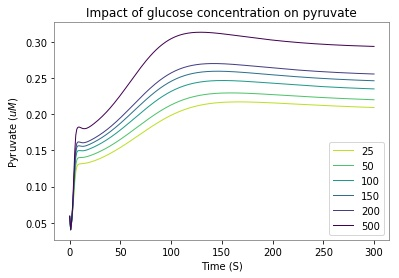

In [7]:
%config InlineBackend.figure_format = 'jpg'
rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='grey')

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)
plt.close('all')

n_lines = 6
glucoseInitials = [25,50,100,150,200,500]
color_idx = np.linspace(0.9, 0, n_lines)
t_span = np.linspace(0, 300, num=300)

for i,n in zip(color_idx,glucoseInitials):
    pyruvate = pd.read_csv('pyruvate{}.csv'.format(n), header=None)
    plt.plot(t_span,pyruvate[0:300], color=plt.cm.viridis(i), lw=1,  label=n)
    plt.legend(loc='lower right')
plt.title('Impact of glucose concentration on pyruvate')
plt.xlabel('Time (S)')
plt.ylabel('Pyruvate ($uM$)')

plt.savefig('pyruvate_composed.jpg', dpi=300)

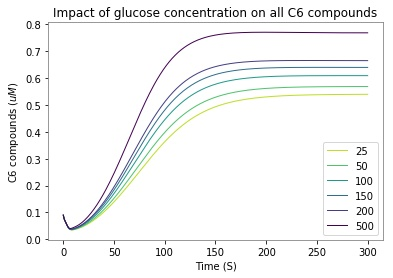

In [9]:
%config InlineBackend.figure_format = 'jpg'
rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='grey')

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)
plt.close('all')

n_lines = 6
glucoseInitials = [25,50,100,150,200,500]
color_idx = np.linspace(0.9, 0, n_lines)
t_span = np.linspace(0, 300, num=300)

for i,n in zip(color_idx,glucoseInitials):
    CIT2C = pd.read_csv('CIT2C{}.csv'.format(n), header=None)
    plt.plot(t_span,CIT2C[0:300], color=plt.cm.viridis(i), lw=1,  label=n)
    plt.legend(loc='lower right')
plt.title('Impact of glucose concentration on all C6 compounds')
plt.xlabel('Time (S)')
plt.ylabel('C6 compounds ($uM$)')

plt.savefig('cit2c_composed.jpg', dpi=300)

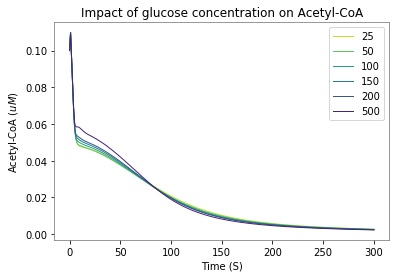

In [8]:
%config InlineBackend.figure_format = 'jpg'
rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='grey')

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=9)
plt.close('all')

n_lines = 6
glucoseInitials = [25,50,100,150,200,500]
color_idx = np.linspace(0.9, 0.1, n_lines)
t_span = np.linspace(0, 300, num=300)

for i,n in zip(color_idx,glucoseInitials):
    AcCoA = pd.read_csv('AcCoA{}.csv'.format(n), header=None)
    plt.plot(t_span,AcCoA[0:300], color=plt.cm.viridis(i), lw=1,  label=n)
    plt.legend(loc='upper right')
plt.title('Impact of glucose concentration on Acetyl-CoA')
plt.xlabel('Time (S)')
plt.ylabel('Acetyl-CoA ($uM$)')

plt.savefig('accoa_composed.jpg', dpi=300)